# Optiver Realized Volatility Prediction - Data Exploration and Analysis

In this notebook, we delve into the `Optiver Realized Volatility Prediction` dataset with the intent of:
1. **Computing Daily Returns**: We will calculate the daily returns for each stock, giving insights into daily movements.
2. **Aligning Stock Data**: Ensuring all stocks are aligned by timestamp and any gaps in data are adequately handled.
3. **Building a Correlation Matrix**: To visualize and understand the relationships between the returns of different stocks.
4. **Clustering Stocks**: Using hierarchical clustering methods to identify groups of stocks with similar behavior (SECTORS/INDUSTRIES)
5. **Principal Component Analysis (PCA)**: Reducing the dimensionality of our data and understanding the primary directions of variance in stock returns.

## Data Preparation and Return Calculation

In this section, we'll take the following steps:

1. **Import Necessary Libraries**: `pandas`, `numpy`, and `plotly.express` will be our primary tools for data handling and visualization.
2. **Load Dataset**: We'll load the 'Optiver Realized Volatility Prediction' training dataset from the given Kaggle path.
3. **Compute Daily Returns**: Using the 'wap' (Weighted Average Price) column, we'll compute the percentage change, which will give us daily returns. This step is essential to understand the daily movement of each stock.
4. **Align Stock Data**: With the help of pivot tables, we'll rearrange our data such that each stock has its own column, and each row corresponds to a specific timestamp (defined by the date and seconds in the bucket). This alignment is vital for comparing stock movements in unison. 
5. **Handle Missing Values**: Given that not all stocks might have data for every timestamp, we'll fill missing values using the average of available data. This step ensures that our subsequent analyses aren't affected by NaN values.
6. **Correlation Matrix Construction**: To identify how different stock returns move in relation to one another, we'll compute a correlation matrix. A high positive value indicates two stocks move in tandem, while a negative value indicates opposite movements.

Finally, we'll print the correlation matrix to get a preliminary view of our results.





In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')

# 1. Compute returns for each stock for each day
# Calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['return'] = stock_data['wap'].pct_change()
    return stock_data[['return', 'seconds_in_bucket']].dropna()  # Keep 'return' and 'seconds_in_bucket' columns

returns = train.groupby(['stock_id', 'date_id']).apply(calculate_daily_returns).reset_index()

# 2. Align the data for each stock by filling in the gaps (if any) and then concatenate the returns to form a matrix
# For this step, we will pivot the data so each stock has its own column, and each row represents a timestamp.
pivot_returns = returns.pivot_table(index=['date_id', 'seconds_in_bucket'], 
                                    columns='stock_id', 
                                    values='return')

# handle missing values by filling the average of all available 
pivot_returns = pivot_returns.apply(lambda row: row.fillna(row.mean()), axis=1)

# 3. Compute the correlation matrix for all stocks
correlation_matrix = pivot_returns.corr()

print(correlation_matrix)

stock_id       0         1         2         3         4         5    \
stock_id                                                               
0         1.000000  0.173563  0.160263  0.435274  0.374570  0.245712   
1         0.173563  1.000000  0.115594  0.198058  0.203573  0.135740   
2         0.160263  0.115594  1.000000  0.188264  0.189967  0.154602   
3         0.435274  0.198058  0.188264  1.000000  0.463210  0.243012   
4         0.374570  0.203573  0.189967  0.463210  1.000000  0.263304   
...            ...       ...       ...       ...       ...       ...   
195       0.375402  0.142486  0.156188  0.446116  0.361474  0.198726   
196       0.289512  0.150790  0.166441  0.333541  0.295877  0.179472   
197       0.273659  0.157008  0.152283  0.305705  0.302936  0.275726   
198       0.373950  0.160541  0.158540  0.422111  0.366702  0.234882   
199       0.245482  0.147967  0.156245  0.310758  0.302447  0.178191   

stock_id       6         7         8         9    ...       190

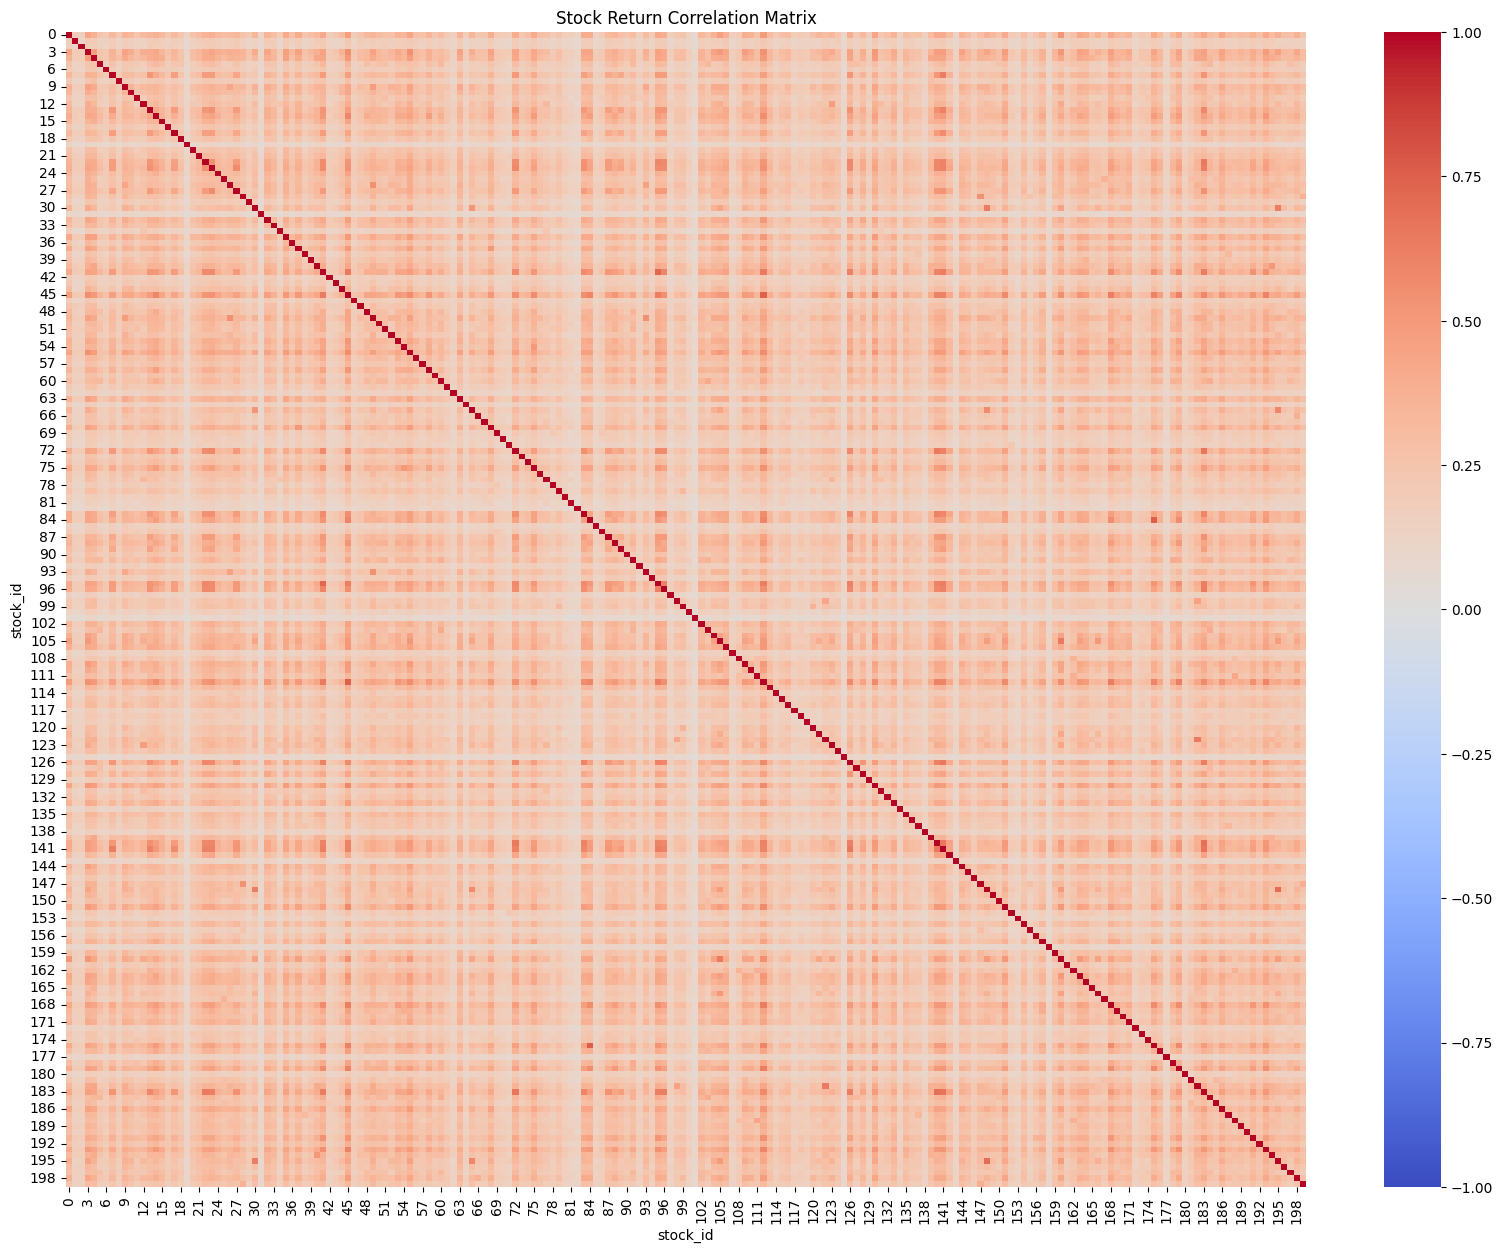

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title('Stock Return Correlation Matrix')
plt.show()

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Hierarchical clustering
Z = linkage(correlation_matrix, 'ward')
clusters = fcluster(Z, 10, criterion = 'maxclust')

# Assign clusters to stocks
stock_clusters = pd.DataFrame({'stock_id': correlation_matrix.index, 'cluster': clusters})
print(stock_clusters)

     stock_id  cluster
0           0        4
1           1        7
2           2        7
3           3        4
4           4        4
..        ...      ...
195       195        5
196       196        9
197       197        3
198       198        5
199       199        9

[200 rows x 2 columns]


### Using Hierarchical Clustering as a Proxy for Sector/Industry Classification

In the financial world, sector classification provides a way to categorize companies into industry segments based on the nature of their business. One of the standard sector classification systems is the Global Industry Classification Standard (GICS). The GICS breaks down the economic landscape into 11 sectors such as Financials, Energy, and Information Technology, among others. This classification aids in understanding the economic drivers, opportunities, and risks associated with particular companies.

However, in a data-driven approach, especially when looking at stock return correlations, sector classifications might not be strictly based on GICS. Instead, through techniques like hierarchical clustering, we can derive clusters that might align with or deviate from traditional sectors. These derived clusters give us an alternative perspective, allowing for the identification of stocks that might statistically move together regardless of their GICS classification. It provides a more granular and dynamic view of market behavior.

In the following cell:

1. We perform hierarchical clustering using the `ward` method, which minimizes the variance between clusters being merged.
2. We'll aim to visualize the dendrogram to see how stocks coalesce into clusters based on their correlation.
3. By choosing to form 10 clusters, we are suggesting that there might be 10 distinct statistical 'sectors' in our data. These may or may not align with traditional GICS sectors, but they represent groupings where stocks have similar movements. Users should play with the number of clusters by looking at the dendrogram. Maybe there should be less clusters given that we are only working with the tech-heavy NASDAQ.
4. Finally, we assign each stock to one of these derived clusters, creating a data-driven sector classification.

Let's proceed and see how our data-driven clusters compare to traditional sector perceptions!


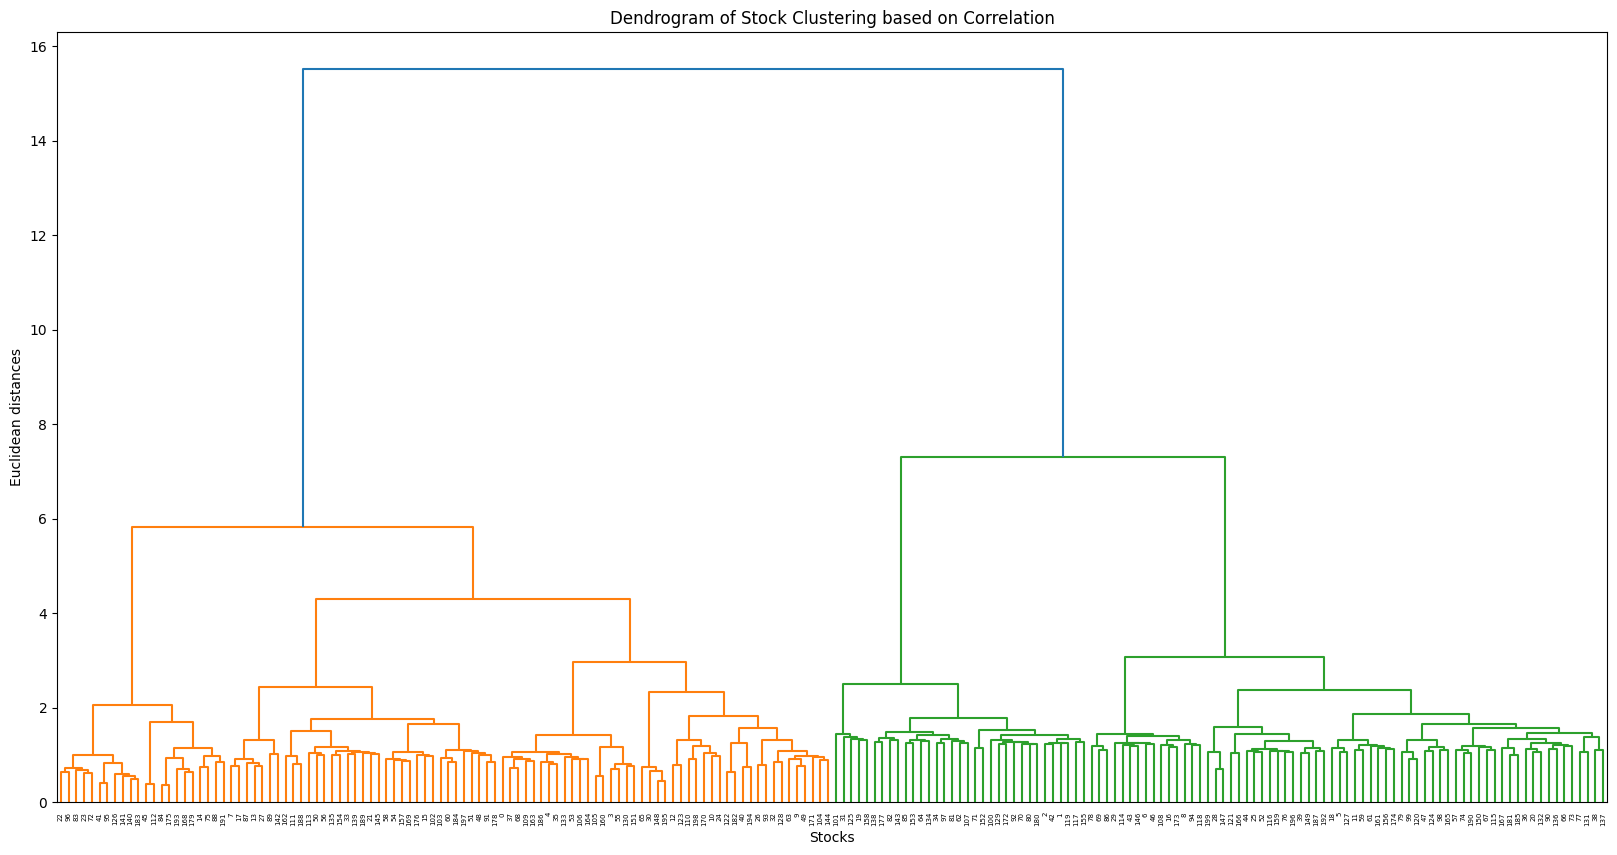

     stock_id  cluster
0           0        4
1           1        7
2           2        7
3           3        4
4           4        4
..        ...      ...
195       195        5
196       196        9
197       197        3
198       198        5
199       199        9

[200 rows x 2 columns]


In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# Hierarchical clustering
Z = linkage(correlation_matrix, 'ward')

# Plotting dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, labels=correlation_matrix.index, leaf_rotation=90)
plt.title('Dendrogram of Stock Clustering based on Correlation')
plt.xlabel('Stocks')
plt.ylabel('Euclidean distances')
plt.axhline(y=1500, color='r', linestyle='--') # This line represents the cut-off for the clusters. Adjust the value as needed.
plt.show()

clusters = fcluster(Z, 10, criterion = 'maxclust')

# Assign clusters to stocks
stock_clusters = pd.DataFrame({'stock_id': correlation_matrix.index, 'cluster': clusters})
print(stock_clusters)


---

### Reordered Correlation Heatmap based on Cluster Assignments

Having applied hierarchical clustering, the stocks have been grouped into clusters that can be interpreted as a statistical proxy for sector classifications, akin to the Global Industry Classification Standard (GICS) sectors.

By reordering the original correlation matrix based on these cluster assignments, we can visually validate the effectiveness of our clustering. In the heatmap that follows, we expect to see distinct blocks of higher correlations for stocks that fall within the same cluster. These blocks would suggest that stocks within a specific cluster move similarly, showcasing internal coherence within that cluster. 

This visualization allows us to gauge how well the clustering has grouped together stocks that display similar price dynamics. While it's worth noting that these clusters might not align perfectly with traditional sector classifications, they do give a statistical sense of how stocks might be related based on their daily return correlations.

---


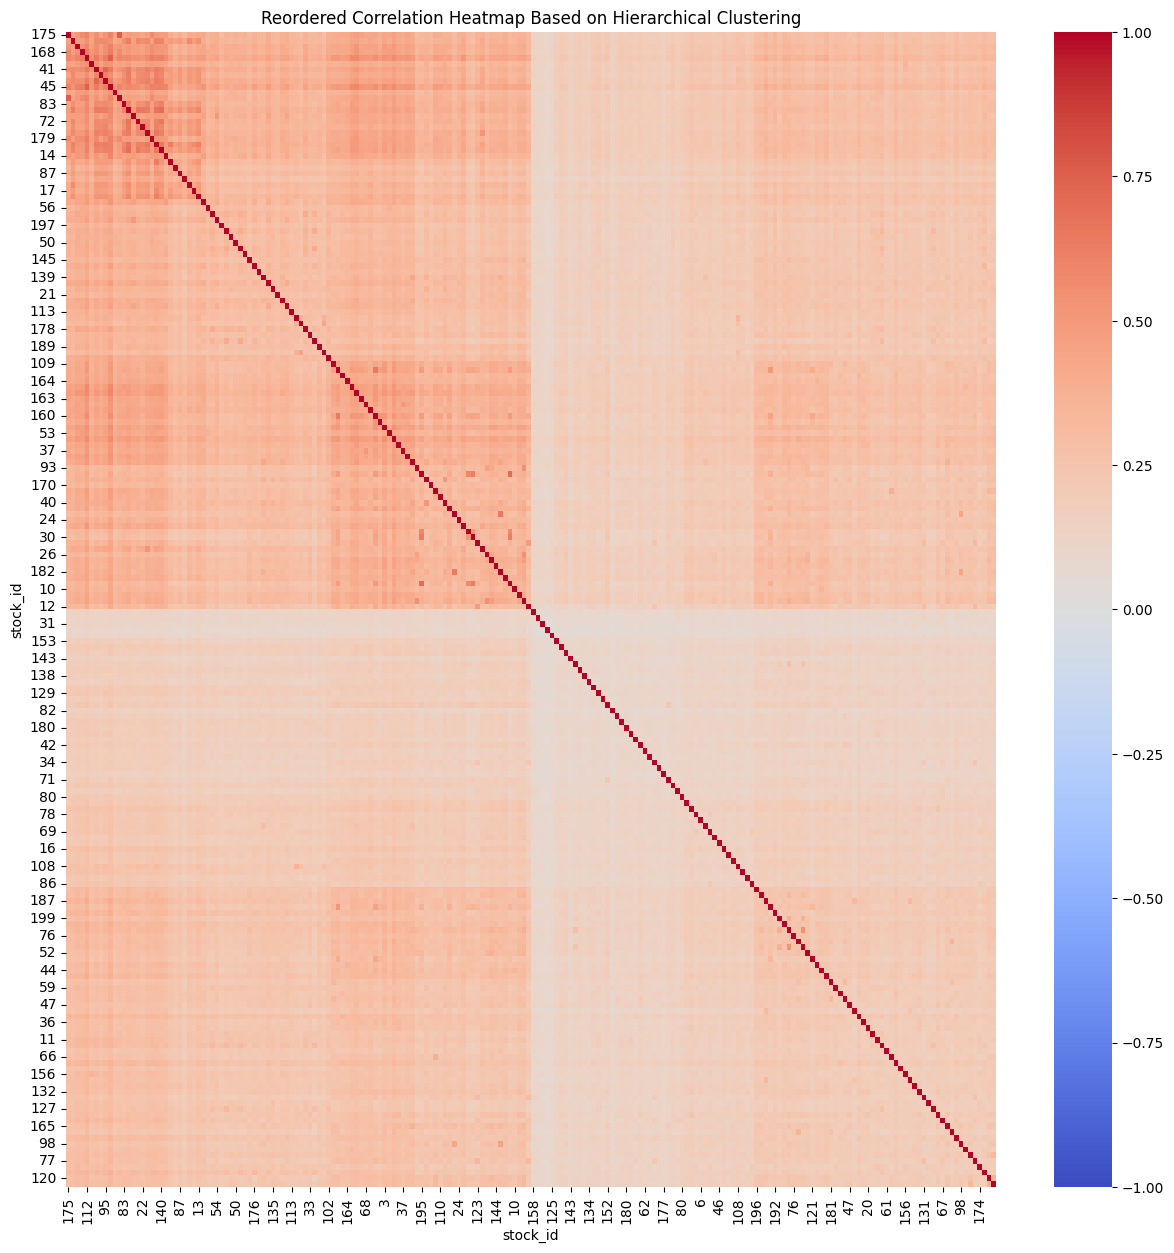

In [5]:
# Reordering the correlation matrix based on cluster assignments
ordered_stocks = stock_clusters.sort_values(by='cluster')['stock_id'].values
ordered_correlation_matrix = correlation_matrix.loc[ordered_stocks, ordered_stocks]

# Plotting the reordered heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
sns.heatmap(ordered_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Reordered Correlation Heatmap Based on Hierarchical Clustering')
plt.show()

---

### Principal Component Analysis (PCA) on Stock Return Data

Principal Component Analysis (PCA) is a dimensionality reduction technique that identifies orthogonal directions (principal components) in the data that maximize variance. Applied to financial data like stock returns, PCA can help capture underlying structures or patterns which might reflect latent market factors.

When applying PCA to financial data, a common dilemma is whether to use the correlation matrix or the covariance matrix:

- **Using the Correlation Matrix**: This approach is appropriate when variables (in this case, stock returns) are measured in different units or have different scales. By standardizing, the PCA will focus on the relationships (or correlations) between stocks.
  
- **Using the Covariance Matrix**: If variables are measured in the same units and scale is not an issue, the covariance matrix can be used. Here, PCA will also consider the variance (magnitude) of each variable, potentially emphasizing stocks with higher volatilities.

For our analysis, we use the correlation matrix, focusing on the relationships between stocks regardless of their individual volatilities. But you can and should play with covariances and see if it changes (and tell me what you find. LOL)

Next, we'll generate a scree plot that focuses on the first 20 principal components. This plot helps in determining the number of components to retain by visualizing the explained "variance" of each component. The point at which the curve starts to flatten (often referred to as the 'elbow') can be used as a guideline for the optimal number of components.

Post the PCA transformation, we'll explore the scores of the first few principal components for each stock and save the resulting matrices for further analysis.

---


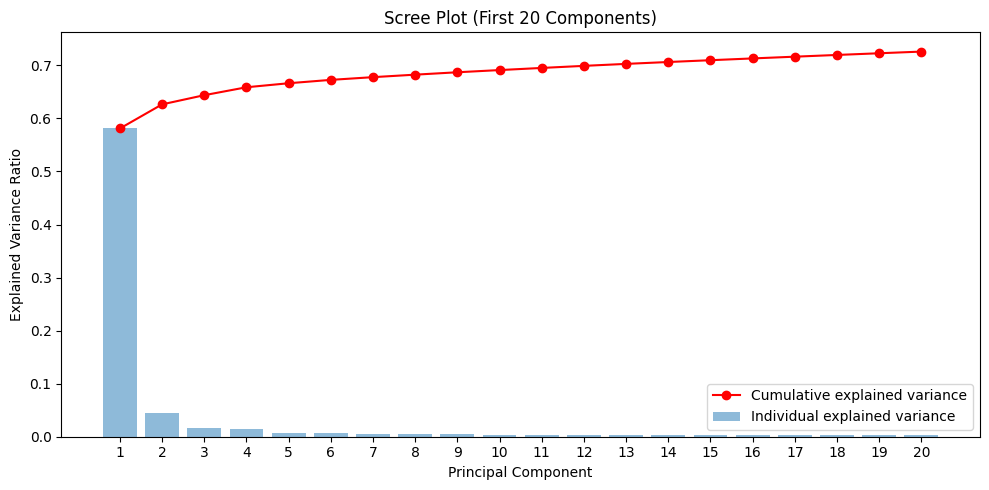

               PC1       PC2       PC3       PC4       PC5       PC6  \
stock_id                                                               
0        -0.756932  0.238704 -0.202629 -0.130516  0.013136 -0.023465   
1         1.208854 -0.080464  0.033121  0.063061 -0.080535 -0.009485   
2         1.269407 -0.101167  0.027279  0.069305 -0.090956 -0.063355   
3        -1.347924  0.439673 -0.019282 -0.004751 -0.016036  0.048241   
4        -1.081945  0.184160  0.223589 -0.009969 -0.012306  0.096677   

               PC7       PC8       PC9      PC10  ...     PC191     PC192  \
stock_id                                          ...                       
0        -0.016329 -0.063845  0.108361  0.094139  ...  0.005594 -0.035291   
1        -0.042645  0.009315 -0.023824  0.004761  ... -0.001659 -0.002939   
2         0.055516 -0.052653  0.001878 -0.066976  ... -0.002588  0.000156   
3        -0.023955  0.029613  0.037294  0.076031  ... -0.019712  0.003494   
4        -0.075880 -0.027755  0.1

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA without limiting the number of components
pca = PCA()
principal_components = pca.fit_transform(correlation_matrix)

# Create a scree plot focusing on the first 20 components
explained_variance = pca.explained_variance_ratio_
n_components = 20
plt.figure(figsize=(10, 5))
plt.bar(range(1, n_components + 1), explained_variance[:n_components], alpha=0.5, align='center', label='Individual explained variance')
plt.plot(range(1, n_components + 1), explained_variance[:n_components].cumsum(), '-o', color='red', label='Cumulative explained variance')
plt.title('Scree Plot (First 20 Components)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, n_components + 1))
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Convert the principal components into a DataFrame
principal_df = pd.DataFrame(data=principal_components, 
                            index=correlation_matrix.index,  # use stock_ids as the index
                            columns=['PC'+str(i) for i in range(1, principal_components.shape[1] + 1)])

print(principal_df.head())  # print first few rows to verify the results

# Save the matrices
correlation_matrix.to_csv('correlation_matrix.csv')
principal_df.to_csv('principal_components.csv')
stock_clusters.to_csv('stock_clusters.csv')


# My intuition is that 2 or 3 factors should be enough here. Let me know your thoughts!

Finally let's add robust PCA. Robust PCA is designed to handle cases where the data may contain outliers. While regular PCA is sensitive to outliers, robust PCA decomposes the data matrix into a low-rank component and a sparse component, where the sparse component captures the outliers.

In [7]:
from sklearn.decomposition import PCA, SparsePCA

# Perform Robust PCA
rpca = SparsePCA(n_components=correlation_matrix.shape[0], alpha=1e-6, ridge_alpha=1e-6, method='lars')
robust_principal_components = rpca.fit_transform(correlation_matrix)

# Convert the robust principal components into a DataFrame
robust_principal_df = pd.DataFrame(data=robust_principal_components, 
                                   index=correlation_matrix.index,  # use stock_ids as the index
                                   columns=['RPC'+str(i) for i in range(1, robust_principal_components.shape[1] + 1)])

print(robust_principal_df.head())  # print first few rows to verify the results

# Save the robust principal components to a csv file
robust_principal_df.to_csv('robust_principal_components.csv')


              RPC1      RPC2      RPC3      RPC4      RPC5      RPC6  \
stock_id                                                               
0        -0.741133  0.237890 -0.201563 -0.128817  0.013084 -0.023382   
1         1.183664 -0.080196  0.032926  0.062213 -0.080530 -0.009456   
2         1.242937 -0.100877  0.027118  0.068365 -0.091000 -0.063127   
3        -1.319841  0.438261 -0.019125 -0.004649 -0.016022  0.048012   
4        -1.059527  0.183576  0.222525 -0.009819 -0.012284  0.096404   

              RPC7      RPC8      RPC9     RPC10  ...    RPC191    RPC192  \
stock_id                                          ...                       
0        -0.015997 -0.063282  0.107365  0.094119  ...  0.005550 -0.035239   
1        -0.041919  0.009254 -0.023631  0.004781  ... -0.001586 -0.002973   
2         0.054378 -0.052173  0.001841 -0.066970  ... -0.002513  0.000107   
3        -0.023458  0.029250  0.037033  0.075955  ... -0.019808  0.003577   
4        -0.074326 -0.027599  0.1

## Sectors according to chatGPT

I just asked chatgpt to classify the companies by sector. I'm using the names as they were found on the notebook https://www.kaggle.com/code/lognorm/de-anonymizing-stock-id

Note that the classification is most likely wrong. An example is tilray which produces cannabis and is classified as "healthcare". Highly debatable but may be useful?

In [8]:
ticker_group_info = {
    166: ('KHC', 'Kraft Heinz Co', 'Consumer Goods'),
    121: ('KDP', 'Keurig Dr Pepper Inc.', 'Consumer Goods'),
    105: ('MDLZ', 'Mondelez International', 'Consumer Goods'),
    151: ('CSCO', 'Cisco Systems, Inc.', 'Technology'),
    170: ('HOLX', 'Hologic, Inc.', 'Healthcare'),
    0: ('MNST', 'Monster Beverage Corporation', 'Consumer Goods'),
    65: ('EXC', 'Exelon Corporation', 'Utilities'),
    109: ('CSX', 'CSX Corporation', 'Transportation'),
    123: ('GILD', 'Gilead Sciences', 'Healthcare'),
    198: ('CMCSA', 'Comcast Corporation', 'Communication Services'),
    131: ('INCY', 'Incyte Corporation', 'Healthcare'),
    21: ('SSNC', 'SS&C Technologies', 'Technology'),
    148: ('XEL', 'Xcel Energy Inc.', 'Utilities'),
    38: ('ATVI', 'Activision Blizzard', 'Communication Services'),
    30: ('LNT', 'Alliant Energy Corporation', 'Utilities'),
    63: ('LKQ', 'LKQ Corporation', 'Consumer Discretionary'),
    24: ('AKAM', 'Akamai Technologies', 'Technology'),
    130: ('SBUX', 'Starbucks Corporation', 'Consumer Discretionary'),
    120: ('FOXA', 'Fox Corporation', 'Communication Services'),
    195: ('AEP', 'American Electric Power', 'Utilities'),
    53: ('EBAY', 'eBay Inc.', 'Consumer Discretionary'),
    81: ('SGEN', 'Seagen Inc.', 'Healthcare'),
    47: ('TXRH', 'Texas Roadhouse, Inc.', 'Consumer Discretionary'),
    154: ('DBX', 'Dropbox, Inc.', 'Technology'),
    160: ('PEP', 'PepsiCo, Inc.', 'Consumer Goods'),
    55: ('FAST', 'Fastenal Company', 'Industrial Goods'),
    37: ('ADP', 'Automatic Data Processing', 'Technology'),
    90: ('FFIV', 'F5 Networks, Inc.', 'Technology'),
    186: ('CTSH', 'Cognizant Technology Solutions', 'Technology'),
    187: ('EA', 'Electronic Arts Inc.', 'Communication Services'),
    76: ('HAS', 'Hasbro, Inc.', 'Consumer Goods'),
    117: ('AGNC', 'AGNC Investment Corp.', 'Financial'),
    134: ('VTRS', 'Viatris Inc.', 'Healthcare'),
    3: ('HON', 'Honeywell International Inc.', 'Industrial Goods'),
    165: ('HST', 'Host Hotels & Resorts', 'Financial'),
    97: ('NBIX', 'Neurocrine Biosciences', 'Healthcare'),
    145: ('CG', 'The Carlyle Group', 'Financial'),
    25: ('EXPD', 'Expeditors International', 'Services'),
    68: ('PAYX', 'Paychex, Inc.', 'Services'),
    52: ('CINF', 'Cincinnati Financial', 'Financial'),
    112: ('LSTR', 'Landstar System', 'Services'),
    181: ('JBHT', 'J.B. Hunt Transport Services', 'Services'),
    28: ('FANG', 'Diamondback Energy', 'Energy'),
    43: ('JKHY', 'Jack Henry & Associates', 'Technology'),
    12: ('AMGN', 'Amgen Inc.', 'Healthcare'),
    149: ('VRSK', 'Verisk Analytics', 'Technology'),
    144: ('PCAR', 'PACCAR Inc', 'Consumer Goods'),
    192: ('PTC', 'PTC Inc.', 'Technology'),
    153: ('HTZ', 'Hertz Global Holdings', 'Services'),
    175: ('GOOGL', 'Alphabet Inc.', 'Technology'),
    189: ('CSGP', 'CoStar Group', 'Technology'),
    116: ('CDW', 'CDW Corporation', 'Technology'),
    35: ('ROST', 'Ross Stores, Inc.', 'Consumer Discretionary'),
    46: ('TECH', 'Bio-Techne Corporation', 'Healthcare'),
    164: ('CPRT', 'Copart, Inc.', 'Consumer Discretionary'),
    44: ('CME', 'CME Group Inc.', 'Financial'),
    146: ('MIDD', 'The Middleby Corporation', 'Industrial Goods'),
    125: ('UTHR', 'United Therapeutics Corporation', 'Healthcare'),
    171: ('TROW', 'T. Rowe Price Group', 'Financial'),
    73: ('GEN', 'Genesis Healthcare, Inc.', 'Healthcare'),
    196: ('XRAY', 'Dentsply Sirona', 'Healthcare'),
    9: ('PFG', 'Principal Financial Group', 'Financial'),
    199: ('BKR', 'Baker Hughes Company', 'Energy'),
    193: ('PYPL', 'PayPal Holdings, Inc.', 'Technology'),
    106: ('TRMB', 'Trimble Inc.', 'Technology'),
    122: ('AAL', 'American Airlines Group', 'Services'),
    4: ('MAR', 'Marriott International', 'Services'),
    176: ('FTNT', 'Fortinet, Inc.', 'Technology'),
    2: ('AXON', 'Axon Enterprise, Inc.', 'Industrial Goods'),
    167: ('CHRW', 'C.H. Robinson Worldwide', 'Services'),
    91: ('DOCU', 'DocuSign, Inc.', 'Technology'),
    128: ('WDC', 'Western Digital Corporation', 'Technology'),
    152: ('SBAC', 'SBA Communications', 'Technology'),
    155: ('CHK', 'Chesapeake Energy', 'Energy'),
    26: ('HBAN', 'Huntington Bancshares', 'Financial'),
    132: ('TSCO', 'Tractor Supply Company', 'Consumer Discretionary'),
    119: ('MASI', 'Masimo Corporation', 'Healthcare'),
    27: ('QRVO', 'Qorvo, Inc.', 'Technology'),
    84: ('GOOGL', 'Alphabet Inc. (again)', 'Technology'),
    23: ('SWKS', 'Skyworks Solutions', 'Technology'),
    110: ('TMUS', 'T-Mobile US', 'Communication Services'),
    182: ('UAL', 'United Airlines Holdings', 'Services'),
    157: ('ADSK', 'Autodesk, Inc.', 'Technology'),
    168: ('AMZN', 'Amazon.com, Inc.', 'Consumer Discretionary'),
    147: ('APA', 'APA Corporation', 'Energy'),
    64: ('MKTX', 'MarketAxess Holdings', 'Financial'),
    190: ('DXCM', 'DexCom, Inc.', 'Healthcare'),
    19: ('ALNY', 'Alnylam Pharmaceuticals', 'Healthcare'),
    1: ('WING', 'Wingstop Inc.', 'Consumer Discretionary'),
    49: ('FITB', 'Fifth Third Bancorp', 'Financial'),
    194: ('PENN', 'Penn National Gaming', 'Consumer Discretionary'),
    140: ('TXN', 'Texas Instruments', 'Technology'),
    133: ('ISRG', 'Intuitive Surgical', 'Healthcare'),
    177: ('SWAV', 'ShockWave Medical', 'Healthcare'),
    32: ('NTAP', 'NetApp, Inc.', 'Technology'),
    22: ('ON', 'ON Semiconductor Corporation', 'Technology'),
    77: ('VRTX', 'Vertex Pharmaceuticals', 'Healthcare'),
    104: ('WBA', 'Walgreens Boots Alliance', 'Consumer Goods'),
    107: ('PODD', 'Insulet Corporation', 'Healthcare'),
    59: ('Z', 'Zillow Group', 'Technology'),
    72: ('ADI', 'Analog Devices', 'Technology'),
    158: ('APLS', 'Apellis Pharmaceuticals', 'Healthcare'),
    169: ('MSFT', 'Microsoft Corporation', 'Technology'),
    94: ('PCTY', 'Paylocity Holding Corporation', 'Technology'),
    66: ('LBRDK', 'Liberty Broadband', 'Communication Services'),
    126: ('MU', 'Micron Technology', 'Technology'),
    139: ('EXPE', 'Expedia Group', 'Consumer Discretionary'),
    159: ('STLD', 'Steel Dynamics', 'Basic Materials'),
    137: ('TTWO', 'Take-Two Interactive Software', 'Technology'),
    78: ('HOOD', 'Robinhood Markets', 'Financial'),
    114: ('LPLA', 'LPL Financial Holdings', 'Financial'),
    141: ('AMAT', 'Applied Materials', 'Technology'),
    15: ('ABNB', 'Airbnb, Inc.', 'Technology'),
    60: ('CRWD', 'CrowdStrike Holdings', 'Technology'),
    183: ('MCHP', 'Microchip Technology', 'Technology'),
    10: ('NDAQ', 'Nasdaq, Inc.', 'Financial'),
    135: ('DKNG', 'DraftKings Inc.', 'Consumer Discretionary'),
    197: ('SPLK', 'Splunk Inc.', 'Technology'),
    99: ('PARA', 'Paramount Global', 'Communication Services'),
    56: ('ETSY', 'Etsy, Inc.', 'Consumer Discretionary'),
    13: ('TER', 'Teradyne, Inc.', 'Technology'),
    62: ('RGEN', 'Repligen Corporation', 'Healthcare'),
    80: ('TXG', '10x Genomics', 'Healthcare'),
    67: ('MRNA', 'Moderna, Inc.', 'Healthcare'),
    178: ('ZM', 'Zoom Video Communications', 'Technology'),
    39: ('CTAS', 'Cintas Corporation', 'Consumer Discretionary'),
    173: ('FIVE', 'Five Below, Inc.', 'Consumer Discretionary'),
    184: ('DDOG', 'Datadog, Inc.', 'Technology'),
    162: ('ENPH', 'Enphase Energy', 'Technology'),
    16: ('ZBRA', 'Zebra Technologies', 'Technology'),
    89: ('ENTG', 'Entegris, Inc.', 'Technology'),
    45: ('MSFT', 'Microsoft Corporation', 'Technology'),
    124: ('ASO', 'Academy Sports and Outdoors', 'Consumer Discretionary'),
    42: ('SAIA', 'Saia, Inc.', 'Services'),
    115: ('ILMN', 'Illumina, Inc.', 'Healthcare'),
    50: ('MTCH', 'Match Group, Inc.', 'Technology'),
    98: ('JBLU', 'JetBlue Airways Corporation', 'Services'),
    103: ('ZS', 'Zscaler, Inc.', 'Technology'),
    40: ('CZR', 'Caesars Entertainment', 'Consumer Discretionary'),
    108: ('SEDG', 'SolarEdge Technologies', 'Technology'),
    179: ('META', 'Meta Platforms, Inc.', 'Technology'),
    6: ('POOL', 'Pool Corporation', 'Consumer Discretionary'),
    100: ('MQ', 'Marqeta, Inc.', 'Technology'),
    48: ('WDAY', 'Workday, Inc.', 'Technology'),
    150: ('PANW', 'Palo Alto Networks', 'Technology'),
    74: ('ALGN', 'Align Technology', 'Healthcare'),
    113: ('LULU', 'Lululemon Athletica', 'Consumer Discretionary'),
    163: ('COST', 'Costco Wholesale Corporation', 'Consumer Discretionary'),
    111: ('SPWR', 'SunPower Corporation', 'Technology'),
    36: ('DLTR', 'Dollar Tree', 'Consumer Discretionary'),
    85: ('CAR', 'Avis Budget Group', 'Services'),
    79: ('WBD', 'Warner Bros. Discovery', 'Communication Services'),
    83: ('INTC', 'Intel Corporation', 'Technology'),
    75: ('CDNS', 'Cadence Design Systems', 'Technology'),
    57: ('IDXX', 'IDEXX Laboratories', 'Healthcare'),
    180: ('GH', 'Guardant Health', 'Healthcare'),
    93: ('ZION', 'Zions Bancorporation', 'Financial'),
    87: ('LSCC', 'Lattice Semiconductor', 'Technology'),
    51: ('ROKU', 'Roku, Inc.', 'Technology'),
    33: ('CROX', 'Crocs, Inc.', 'Consumer Goods'),
    58: ('ROP', 'Roper Technologies', 'Industrial Goods'),
    7: ('LRCX', 'Lam Research Corporation', 'Technology'),
    172: ('APP', 'AppLovin Corporation', 'Technology'),
    61: ('LYFT', 'Lyft, Inc.', 'Technology'),
    185: ('ODFL', 'Old Dominion Freight Line', 'Services'),
    102: ('TEAM', 'Atlassian Corporation', 'Technology'),
    188: ('RUN', 'Sunrun Inc.', 'Technology'),
    17: ('KLAC', 'KLA Corporation', 'Technology'),
    88: ('NFLX', 'Netflix, Inc.', 'Communication Services'),
    95: ('AMD', 'Advanced Micro Devices', 'Technology'),
    14: ('ADBE', 'Adobe Inc.', 'Technology'),
    54: ('SNPS', 'Synopsys, Inc.', 'Technology'),
    18: ('ZI', 'ZoomInfo Technologies', 'Technology'),
    129: ('CFLT', 'Confluent, Inc.', 'Technology'),
    136: ('LITE', 'Lumentum Holdings', 'Technology'),
    191: ('TSLA', 'Tesla, Inc.', 'Consumer Goods'),
    20: ('ULTA', 'Ulta Beauty, Inc.', 'Consumer Discretionary'),
    161: ('PTON', 'Peloton Interactive', 'Consumer Discretionary'),
    5: ('OKTA', 'Okta, Inc.', 'Technology'),
    71: ('EQIX', 'Equinix, Inc.', 'Technology'),
    34: ('REGN', 'Regeneron Pharmaceuticals', 'Healthcare'),
    142: ('AVGO', 'Broadcom Inc.', 'Technology'),
    92: ('MSTR', 'MicroStrategy Incorporated', 'Technology'),
    156: ('LCID', 'Lucid Group, Inc.', 'Consumer Goods'),
    41: ('NVDA', 'NVIDIA Corporation', 'Technology'),
    69: ('SOFI', 'SoFi Technologies, Inc.', 'Financial'),
    138: ('SMCI', 'Super Micro Computer', 'Technology'),
    174: ('AFRM', 'Affirm Holdings', 'Technology'),
    11: ('COIN', 'Coinbase Global', 'Financial'),
    70: ('BYND', 'Beyond Meat, Inc.', 'Consumer Goods'),
    96: ('MRVL', 'Marvell Technology', 'Technology'),
    118: ('FCNCA', 'First Citizens BancShares', 'Financial'),
    29: ('ORLY', "O'Reilly Automotive", 'Consumer Discretionary'),
    143: ('TLRY', 'Tilray Brands', 'Healthcare'),
    86: ('ONEW', 'OneWater Marine', 'Consumer Discretionary'),
    82: ('OPEN', 'Opendoor Technologies', 'Technology'),
    127: ('MDB', 'MongoDB, Inc.', 'Technology'),
    101: ('FCNCA', 'First Citizens BancShares', 'Financial'),  # Duplicate of 118
    8: ('BKNG', 'Booking Holdings Inc.', 'Services'),
    31: ('NVCR', 'NovoCure Limited', 'Healthcare')

}

# Creating a DataFrame for the next group of tickers
df_tickers = pd.DataFrame.from_dict(ticker_group_info, orient='index', columns=['Ticker', 'Company Name', 'Sector'])
df_tickers.reset_index(inplace=True)
df_tickers.rename(columns={'index': 'Key'}, inplace=True)

df_tickers.head() 

,Key,Ticker,Company Name,Sector
0,166,KHC,Kraft Heinz Co,Consumer Goods
1,121,KDP,Keurig Dr Pepper Inc.,Consumer Goods
2,105,MDLZ,Mondelez International,Consumer Goods
3,151,CSCO,"Cisco Systems, Inc.",Technology
4,170,HOLX,"Hologic, Inc.",Healthcare


While this is closer to the "correct" sector classification, there is a lot of concentration on 3 or 4 sectors.

In [9]:
from collections import Counter
print(df_tickers.shape)
Counter(df_tickers.Sector)

(200, 4)


Counter({'Technology': 78,
         'Healthcare': 29,
         'Consumer Discretionary': 25,
         'Financial': 18,
         'Services': 14,
         'Consumer Goods': 12,
         'Communication Services': 9,
         'Industrial Goods': 5,
         'Utilities': 4,
         'Energy': 4,
         'Transportation': 1,
         'Basic Materials': 1})

Finally, my intuition says that we should add some measure of market capitalization. I've built a couple of high frequency models and the things that matters are mostly measures of volatility, liquidity (which we have), and market cap which... we kind of don't have (You could argue that market imbalances could be a proxy for this though, but I think the market cap will work)

In [10]:
df = pd.read_csv('/kaggle/input/nasdaq-index-price-201011-to-now/data_origin/FS_nasdaq_stats.csv')[['Ticker', 'Attribute', 'Recent']]
df = df[df.Attribute == 'Enterprise Value 3'].drop('Attribute', axis = 1)
df.columns = ['Ticker', 'Market Value']
df = df_tickers.merge(df, on = 'Ticker', how = 'left')
df.head()
df.columns = ['stock_id', 'ticker', 'name', 'sectorname', 'marketvalue']
print(df.shape)
df.head()

(200, 5)


,stock_id,ticker,name,sectorname,marketvalue
0,166,KHC,Kraft Heinz Co,Consumer Goods,74.29B
1,121,KDP,Keurig Dr Pepper Inc.,Consumer Goods,63.27B
2,105,MDLZ,Mondelez International,Consumer Goods,106.95B
3,151,CSCO,"Cisco Systems, Inc.",Technology,213.41B
4,170,HOLX,"Hologic, Inc.",Healthcare,18.87B


In [11]:
def convert_to_float(value):
    if isinstance(value, str):
        if value.endswith('B'):
            return float(value.replace('B', '')) * 1e9
        elif value.endswith('M'):
            return float(value.replace('M', '')) * 1e6
        elif value.endswith('T'):
            return float(value.replace('T', '')) * 1e12
        else:
            return float(value)
    return value

# Apply the function to the 'marketvalue' column
df['marketvalue'] = df['marketvalue'].apply(convert_to_float)

# Now you can safely convert it to float32
df['marketvalue'] = df['marketvalue'].astype('float32')

In [12]:
df.to_csv('sectornames_and_marketcap.csv', index = False)